# An Introduction to Latent Semantic Analysis

By James Gopsill

<hr>

This python notebook demonstrates how to perform [Latent Semantic Analysis (LSA)][1] on a corpus of text. There are a couple of other tutorials (see [here][3]) that this example builds upon and I hope the python along with the theory will help you out in using this technique for your own research.

LSA was originally patented back in 1988 and invented by Deerwester at al., (1988). Examples of its application are in identifying similarity in documents, marking of exams and indexing of webpages ([Dumais, 2004;][4] [Deerwester et al., 1990][5]; [Haley at al., 2007;][6] [Landauer, 2003][7]). LSA has also been used in analyse engineering documentation ([Dong, 2005][8]; [Gopsill et al., 2014][9]). A detailed overview of LSA is given by [Thomo (2009)][10] whilst this is purely introductory exercise to show you how to apply it to textual data.

In this example, we are going to analyse the titles of a set of papers from the [DESIGN 2012][2] conference to determine their similarity. This information could be useful to conference organisers wishing to group similar research together and/or as part of a search tool for the attendees to find similar work that might be of interest.

We will be treating each abstract as a list of words. From this, will form a word-title matrix with the column vectors representing the abstracts (and thus, paper), and the row vectors representing the words. There are four key steps to the analysis and we will be stepping through each one with the code and output from each stage being explained. The stages are:

* Generating a list of words from the abstracts
* Creating the word-abstract matrix
* Applying the Term Frequency - Inverse Document Frequency (TF-IDF) Weighting Scheme
* Using Singular Value Decomposition (SVD) to derive the underlying concepts across the documents

Before we get underway, we need to first import all the packages that we will be using. These are:

* Numpy - for handling matrices and the svd function
* Matplotlib - for plotting
* json - for parsing json objects into python
* pprint - pretty printing results to the console
* collections - for counting the number of duplicate occurrences of items in a list
* stop_words - a list of common words used to form sentences
* scipy - for cosine similarity

[1]: https://en.wikipedia.org/wiki/Latent_semantic_analysis
[2]: https://www.designsociety.org/publication/30980/ds_70_proceedings_of_design_2012_the_12th_international_design_conference_dubrovnik_croatia
[3]: https://technowiki.wordpress.com/2011/08/27/latent-semantic-analysis-lsa-tutorial/
[4]: http://dx.doi.org/10.1002/aris.1440380105
[5]: http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1097-4571(199009)41:6%3C391::AID-ASI1%3E3.0.CO;2-9/epdf
[6]: http://dl.acm.org/citation.cfm?id=1273672.1273677
[7]: http://www.tandfonline.com/doi/abs/10.1080/0969594032000148154
[8]: http://www.sciencedirect.com/science/article/pii/S0142694X05000050
[9]: https://jamesgopsill.github.io/Publications/papers/conference/smc2013/smc2013.pdf
[10]: http://www.engr.uvic.ca/~seng474/svd.pdf

### Citation

```
@inproceedings{gopsill2013,
	doi = {10.1109/smc.2013.818},
	url = {https://doi.org/10.1109%2Fsmc.2013.818},
	year = 2013,
	month = {oct},
	publisher = {{IEEE}},
	author = {James A. Gopsill and Stephen J. Payne and Ben J. Hicks},
	title = {An Exploratory Study into Automated Real-Time Categorisation of Engineering E-Mail},
	booktitle = {2013 {IEEE} International Conference on Systems, Man, and Cybernetics}
}
```

In [1]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Importing the packages that we need
import numpy as np # For matrices and SVD function
import matplotlib
import matplotlib.pyplot as plt # For plotting 
import json # To read in JSON data
from pprint import pprint # To pretty print text output to console
import collections
from stop_words import get_stop_words
from scipy.spatial.distance import cosine

## Generating a list of words

Before we can form a word-title matrix of words against titles, we need to decide on the list of words that we will be using to compare the abstracts. The first thing we need to do is load up the dataset. The dataset is formatted as a JSON object and this is parsed into python as a list of dictionaries.

In [2]:
# load the data from the file
with open('DESIGN2012.json', 'r', encoding='iso-8859-15') as f:
    data = f.read()

# read json object
data = json.loads(data)
papers = data['rows']
# pretty print an example data row
pprint(papers[0])


{'publication_author': 'Achiche S., Howard T. J., McAloone T. C., Deng L., '
                       'Baron L.',
 'publication_conf_code': 'DESIGN 2012',
 'publication_keyword': 'new product development, success criteria and '
                        'factors, project management',
 'publication_title': 'THE UNDERLYING RELATIONSHIPS BETWEEN SUCCESS CRITERIA '
                      '&amp; SUCCESS FACTORS IN NPD ACTIVITIES'}


Next, we generate a list of the words that are potentially of interest to us. Here, we count the number of times the words appear within the titles and perform checks such as whether the words exist in the stop words list. The stop word list contains words that are typical words that are used to form sentences.

In [3]:
# Generate words list from publication titles
number_of_papers = len(papers)
words_list = []
for i in range(0, number_of_papers):
    papers[i]['publication_title'] = papers[i]['publication_title'].upper()
    words_in_title = papers[i]['publication_title'].split()
    words_list.extend(words_in_title)

print('Total Number of Words:', len(words_list))

# Count the unique number of words
word_counts = collections.Counter(words_list)
word_counts = word_counts.most_common()
print('Number of Unique Words:', len(word_counts))
print('Most Occurring Words')
pprint(word_counts[0:5])

# Getting the stopwords list
stop_words = get_stop_words('english')
stop_words = [x.upper() for x in stop_words] # Making all the stopwords upper case to match titles
print('Example Stopwords')
pprint(stop_words[0:5])

words_of_interest = []
for word in word_counts:
    if word[1] > 1:
        if word[0] not in stop_words and '&' not in word[0] and len(word[0]) > 1:
            words_of_interest.append(word[0])
    else:
        # break as the frequency of that word is too low for our interest 
        # (and do will the subsequent words be as the list is in order of most common)
        break

number_of_words = len(words_of_interest)
print('Number of Words of Interest:', number_of_words)

Total Number of Words: 2162
Number of Unique Words: 801
Most Occurring Words
[('OF', 121), ('DESIGN', 98), ('FOR', 73), ('A', 69), ('IN', 65)]
Example Stopwords
['A', 'ABOUT', 'ABOVE', 'AFTER', 'AGAIN']
Number of Words of Interest: 225


## Creating the word-title count matrix

Now that we have the words that we're interested in and the paper titles, we can form the word-title matrix where we count the number of times each word appears in each title. The rows of the matrix represent the words and the columns represent the titles of the papers.

In [4]:
m = np.zeros( (number_of_words, number_of_papers) )
print(m.shape)

for i in range(0, number_of_words):
    for j in range(0, number_of_papers):
        words_in_title = papers[j]['publication_title'].split()
        m[i,j] = words_in_title.count(words_of_interest[i])
        
print(m)

(225, 211)
[[ 0.  1.  0. ...,  0.  0.  2.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


## Creating the TF-IDF Matrix

From this matrix, we can formulate the term frequency-inverse document frequency (TF-IDF) matrix. The objective of TF-IDF is to normalise the words based on their occurrence across the entire document set and to highlight the terms that are most significant to each document. There are a number of versions of the TF-IDF and below is one of the most common.

### Term Frequency

The term frequency here is calculated as the number of times the term appears in the title. Other variants include binary, log normalisation and double normalisation.

$$ \mathrm{tf}(t, d) = f_{t,d} $$ 

### Inverse-Document Frequency

The inverse-document frequency aims to reduce the impact of words that occur frequently across the entire set of papers and emphasise the terms that occur rarely across the papers. This aims to highlight the unique features of each title whilst reducing the impact of terms that often appear. Again, there are a variety of ways that the inverse-document frequency can be calculated. 

$$ \mathrm{idf}(t, D) = \log \frac{N}{|\{d \in D\ : t \in d \}|} $$

### Tf-idf

The final tf-idf is then simply the multiplication of the tf and idf.

$$ \mathrm{tfidf}(t, d) = \mathrm{tf}(t, d) \cdot  \mathrm{idf}(t, D) $$

(for more schemes, please read the [wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))

In [5]:
tfidf = np.zeros( (number_of_words, number_of_papers) )

words_per_title = np.sum(m, axis=0)
titles_per_word = np.sum(np.asarray(m > 0, 'i'), axis=1)

for i in range(0, number_of_words):
    for j in range(0, number_of_papers):
        tfidf[i,j] = ( m[i,j] ) * np.log( float(number_of_papers) / titles_per_word[i] )
        
print(tfidf)
        
        
    

[[ 0.          0.89751084  0.         ...,  0.          0.          1.79502167]
 [ 0.          0.          1.54519564 ...,  0.          0.          0.        ]
 [ 0.          0.          1.9845623  ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


## Singular Value Decomposition

Singular Value Decomposition (SVD) is the factorisation of a real or complex matrix. The method produces three matrices:

$$ M = U \sum V $$

This calculation is performed by the [numpy][1] python package. The $\sum$ can be considered to be a scaling matrix and highlights the relative importance of that factor in its contribution to the original matrix.


[1]: (http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)


In [6]:
U, S, Vt = np.linalg.svd(tfidf)

print('U Matrix:', U.shape)
print('S Column:', S.shape)
print('Vt Matrix:', Vt.shape)


U Matrix: (225, 225)
S Column: (211,)
Vt Matrix: (211, 211)


## Plotting the Results

Now that we have the results from the SVD, we can use them to uncover the relationships between the terms and titles. Figure 1 shows the significance of each $\sum$. As we can see, it tails off the further down the list we go. The steeper the line shows that the tf-idf matrix can be represented by fewer concept vectors.

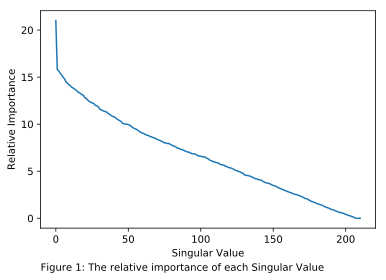

In [7]:
ind = np.arange(len(S))
width = 0.8

plt.plot(ind, S)
plt.xlabel('Singular Value')
plt.ylabel('Relative Importance')
plt.annotate('Figure 1: The relative importance of each Singular Value', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

### Clustering by three dimensions

To show the power of LSA, we can plot and compare the first three concept vectors for titles 1-10 (Figure 2). This highlights the similarity of the papers in relation to these three concepts.

DESIGN [-0.13659356 -0.07296021 -0.05578946]
PRODUCT [ 0.21460004 -0.13364657  0.24625988]
DEVELOPMENT [ 0.273407    0.02515281  0.22053825]
ENGINEERING [-0.10836121  0.00909842 -0.17775233]
SYSTEMS [-0.02848056 -0.11700444 -0.17565461]
-----
Singular Values: [ 15.80655713  15.66813855  15.42168573]
-----
THE UNDERLYING RELATIONSHIPS BETWEEN SUCCESS CRITERIA &AMP; SUCCESS FACTORS IN NPD ACTIVITIES
[ 0.12941572 -0.13631703  0.0588798 ]
TARGET VALUE DESIGN
[ 0.00069599 -0.00364242 -0.00800743]
TOWARDS AN INTEGRATION OF SUPPLY CHAIN REQUIREMENTS INTO THE PRODUCT DEVELOPMENT PROCESS
[ 0.04769812  0.03439986  0.03346327]
TECHNICAL-COMMERCIAL INTERFACE - A BASELINE FOR SUCCESSFUL NEW PRODUCT DEVELOPMENT
[ 0.05604139 -0.03161074  0.03144235]
MATURITY BASED IMPROVEMENT OF PRODUCT DEVELOPMENT PROCESSES IN SMALL AND MEDIUM-SIZED ENTERPRISES
[ 0.07536557 -0.02198135  0.07584032]


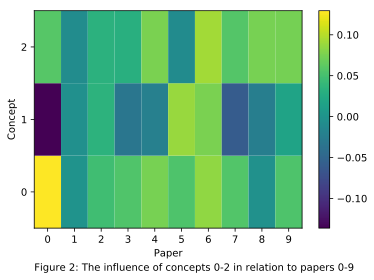

In [8]:
for i in range(0, 5):
    print(words_of_interest[i], U[i,1:4])

print('-----')
print('Singular Values:', S[1:4])
print('-----')

for i in range(0, 5):
    print(papers[i]['publication_title'])
    print(Vt[1:4, i])
    
    
plt.pcolor(Vt[1:4, 0:10], cmap='viridis')
plt.xticks([x+0.5 for x in range(0, 10)], [x for x in range(0, 10)])
plt.yticks([x+0.5 for x in range(0, 3)], [x for x in range(0, 3)])
plt.xlabel('Paper')
plt.ylabel('Concept')
plt.colorbar()
plt.annotate('Figure 2: The influence of concepts 0-2 in relation to papers 0-9', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

### Mapping Words and Titles

In addition, we can try and visualise how the terms in the titles and papers are clustered by comparing the values for the different concepts that have been generated. Below shows the potential clustering in relation to concept 2 and 3. In our case, concept 1 correlates with the number of times that a word has been used in all documents. We could remove this correlation by centering by substracting the term frequencies within each paper titles by the average length of title. By not doing this, we have kept the matrix sparse and hence reduced the computational time required to perform the LSA.

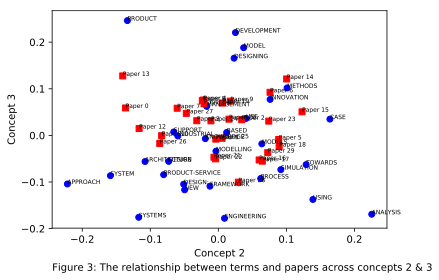

In [9]:
for i in range(0, 30):
    plt.plot(U[i,2], U[i,3], 'ob', alpha=0.5)
    plt.text(U[i,2], U[i,3], words_of_interest[i], fontsize=6)
    
for i in range(0, 30):
    plt.plot(Vt[2,i], Vt[3,i], 'sr', alpha=0.5)
    plt.text(Vt[2,i], Vt[3,i], 'Paper '+str(i), fontsize=6)

plt.xlabel('Concept 2')
plt.ylabel('Concept 3')
plt.annotate('Figure 3: The relationship between terms and papers across concepts 2 & 3', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

### Identifying Similar Documents

The power of LSA is identify similar paper titles and thus, ones that may also be of interest to the reader. This example takes the first 25 concept vectors and identifies similar titles to title 15 "OPEN INNOVATION PRACTICES IN A CLUSTER CONTEXT: A MEDICON VALLEY CASE STUDY" by calculating the cosine similarity. This is defined as:

$$ \frac{\sum^n_{i=1}A_iB_i}{\sqrt{\sum^n_{i=1}A^2_i}\sqrt{\sum^n_{i=1}B^2_i}} $$

where $A_i$ and $B_i$ are components of vector $A$ and $B$ respectively.

As you would expect (and a check for us!), the most similar title is the title itself. This is followed by 3 papers all with "CASE STUDY" within the title. Clearly, "CASE STUDY" is a key identifying factor in the dataset. Further down the list, we see that "CASE" and "INNOVATION" are the terms that link the titles in their similarity.

In [10]:
paper_of_interest = 15
paper_vector = Vt[1:25, paper_of_interest]

cosine_similarity = []
for i in range(0, number_of_papers):
    vector = Vt[1:25, i]
    cosine_distance = cosine(paper_vector, vector) # nearer to one the higher the similarity
    cosine_similarity.append([i, cosine_distance])
    
cosine_similarity = np.asarray(cosine_similarity)

cosine_similarity = cosine_similarity[np.argsort(cosine_similarity[:, 1])]

print('- Paper of Interest -')
print(papers[paper_of_interest]['publication_title'])

print('- Similar Titled Papers -')
for i in range(0, 10):
    paper_id = int(cosine_similarity[i,0])
    print('Paper ID:', paper_id, '-', papers[paper_id]['publication_title'])



    

- Paper of Interest -
OPEN INNOVATION PRACTICES IN A CLUSTER CONTEXT: A MEDICON VALLEY CASE STUDY
- Similar Titled Papers -
Paper ID: 15 - OPEN INNOVATION PRACTICES IN A CLUSTER CONTEXT: A MEDICON VALLEY CASE STUDY
Paper ID: 159 - TRACEABILITY CASE STUDY ON RAIL VEHICLE CONTROL UNIT DEVELOPMENT PROJECT
Paper ID: 94 - MANUFACTURABILITY AND VALIDATION METHODS IN PASSENGER CAR DEVELOPMENT  AN INDUSTRIAL CASE STUDY
Paper ID: 154 - REQUIREMENT ANALYSIS FOR CONTEXTUAL MANAGEMENT AND SUPPLY OF PROCESS- AND DESIGN KNOWLEDGE  A CASE STUDY
Paper ID: 76 - DESIGN FOR INNOVATION
Paper ID: 62 - CASE EXAMPLE IN SYSTEMATIC DESIGN ENGINEERING - PROPELLER SHAFT BEARING ARRANGEMENT
Paper ID: 61 - CASE EXAMPLE IN SYSTEMATIC DESIGN ENGINEERING - LEEBOARD MOUNTING
Paper ID: 205 - THE AMBIGUOUS ROLE OF METHODS IN DESIGN EDUCATION: INITIAL FINDINGS FROM THE DELFT METHOD STUDY
Paper ID: 164 - TRACEABILITY VISUALISATION TOOLKIT
Paper ID: 21 - A DESIGN CASE OF PRODUCT-SERVICE SYSTEMS  URBAN UMBRELLA RENTAL PS

We can also do this for words to find out words that are used in similar contexts.

In [11]:
word_of_interest = 15
word_vector = U[word_of_interest, 1:25]

cosine_similarity = []
for i in range(0, number_of_papers):
    vector = U[i, 1:25]
    cosine_distance = cosine(word_vector, vector) # nearer to one the higher the similarity
    cosine_similarity.append([i, cosine_distance])
    
cosine_similarity = np.asarray(cosine_similarity)

cosine_similarity = cosine_similarity[np.argsort(cosine_similarity[:, 1])]
#print(cosine_similarity[0:5])

print('- Word of Interest -')
print(words_of_interest[word_of_interest])

print('- Similar Words by Concept -')
for i in range(0, 10):
    word_id = int(cosine_similarity[i,0])
    print('Word ID:', word_id, '-', words_of_interest[i])

- Word of Interest -
DESIGN:
- Similar Words by Concept -
Word ID: 15 - DESIGN
Word ID: 42 - PRODUCT
Word ID: 21 - DEVELOPMENT
Word ID: 89 - ENGINEERING
Word ID: 137 - SYSTEMS
Word ID: 132 - APPROACH
Word ID: 133 - ANALYSIS
Word ID: 134 - SYSTEM
Word ID: 43 - MODEL
Word ID: 182 - BASED


Finally, we can look at the concept vectors and see which words feature heavily within it.

In [12]:
print()
print('- Concept Two -')
word_indices = np.argsort(U[:,1])
word_indices = word_indices[0:15]
print(word_indices)
for word_ind in word_indices:
    print(words_of_interest[word_ind])
    
print()
print('- Concept Three -')
word_indices = np.argsort(U[:,2])
word_indices = word_indices[0:15]
print(word_indices)
for word_ind in word_indices:
    print(words_of_interest[word_ind])
    
print()
print('- Concept Four -')
word_indices = np.argsort(U[:,3])
word_indices = word_indices[0:15]
print(word_indices)
for word_ind in word_indices:
    print(words_of_interest[word_ind])
    


- Concept Two -
[ 28 145 148 146  86  85  14  83 147  24  66   0 205 216   3]
DESIGNING
STATE
FUTURE
ART
IMPACT
INTERACTION
MANAGEMENT
REVIEW
EMERGING
USE
RESEARCH
DESIGN
CHALLENGES
VARIANT
ENGINEERING

- Concept Three -
[  5   7  47   1  63  66   4  41  46  18  64 125  62 105 186]
APPROACH
SYSTEM
SUCCESS
PRODUCT
SOLUTION
RESEARCH
SYSTEMS
PROJECTS
EVALUATION
ARCHITECTURE
MODULAR
FAMILIES
ENVIRONMENTAL
FACTORS
METHODICAL

- Concept Four -
[  3   4   6  61  10  21  55  19  15   5 142  13 195   7  44]
ENGINEERING
SYSTEMS
ANALYSIS
IMPROVE
USING
NEW
INTEGRATED
FRAMEWORK
DESIGN:
APPROACH
PRINCIPLES
PROCESS
BETTER
SYSTEM
CONCEPTUAL


## Potential Improvements

* Considering tri-grams & bi-grams
* Stemming
* Synonyms

## Reference and Further Reading

[LSA Tutorial](https://technowiki.wordpress.com/2011/08/27/latent-semantic-analysis-lsa-tutorial/)

[Wikipedia: SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)

[Wikipedia: LSA](https://en.wikipedia.org/wiki/Latent_semantic_analysis)

[Wikipedia: TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)